In [12]:
from sqlalchemy import create_engine, URL
import glob, os 
from dotenv import load_dotenv, find_dotenv 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
import numpy as np

---
### EXTRACTION DE DONNEES

In [13]:
def extract_data() -> pd.DataFrame: 
    return pd.concat([pd.read_csv(f) for f in glob.glob('datasets/*.csv')])

In [14]:
extracted_data = extract_data()

In [15]:
extracted_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001"
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001"
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001"
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016"
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301"


In [16]:
extracted_data.columns

Index(['Order ID', 'Product', 'Quantity Ordered', 'Price Each', 'Order Date',
       'Purchase Address'],
      dtype='object')

---
### TRANSFORMATION DE DONNEES 

- Renommer toutes les colonnes ayant un espace dans le nom (exemple la colonne 'Quantity Ordered' sera renommée QuantityOrdered,  etc)

- Convertir en int ou float les colonnes numériques representées sous forme de chaine de caractère

- Convertir la colonne date to datetime

- Créer une nouvelle colonne Hour à partir de la colonne Date et inserer juste apres cette derniere

- Identifier et supprimer les données dupliquées

- Identifier et traiter (c'est à dire les remplacer, les retrouver ou les supprimer) les valeurs manquantes

- Identifier et traiter (c'est à dire les remplacer, les retrouver ou les supprimer) les valeurs aberrantes

- Afficher la liste de 10 premiers produits les plus vendus 

- Afficher la liste de 10 produits les moins vendus  

- Afficher les produits les plus vendus durant le mois de decembre


In [17]:
def convert_data_types(df:pd.DataFrame) -> None:
    num_vars = ['Quantity Ordered', 'Price Each']
    # cat_vars = ['']
    # date_vars = ['Order Date']
    # df = df.convert_dtypes()
    
    # df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst = True)
    for col in num_vars:
        df[col] = pd.to_numeric(df[col], errors = 'coerce')

In [18]:
def transform_data(df:pd.DataFrame) -> pd.DataFrame:
    convert_data_types(df)
    return df

In [19]:
cleaned_data = transform_data(extracted_data)

In [20]:
cleaned_data.rename(columns={'Quantity Ordered':'QuantityOrdered',
                            'Price Each': 'PriceEach', 
                            'Order Date':'OrderDate'}, inplace=True)

In [21]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186850 entries, 0 to 13621
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Order ID          186305 non-null  object 
 1   Product           186305 non-null  object 
 2   QuantityOrdered   185950 non-null  float64
 3   PriceEach         185950 non-null  float64
 4   OrderDate         186305 non-null  object 
 5   Purchase Address  186305 non-null  object 
dtypes: float64(2), object(4)
memory usage: 10.0+ MB


<Axes: >

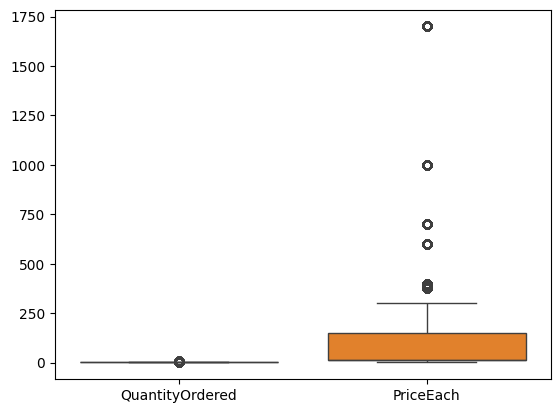

In [22]:
sns.boxplot(data = cleaned_data.select_dtypes('number'))

In [27]:
sns.pairplot(data = cleaned_data)

TypeError: pairplot() got an unexpected keyword argument 'x'

---
### LOAD DATA

- Se connecter à une base de données Postgres (il faut l'avoir installée au prealable sur sa machine et créee une base de données mydb et un utilisateur myuser avec ses identifiants de connexion)

- Ecrire un algorithme qui permet de charger les données que vous venez de nettoyer à la base de données mydb

In [ ]:
load_dotenv(find_dotenv())

In [ ]:
DATABASE_URL = URL.create(
    "postgresql+psycopg2",
    username = os.getenv("DATABASE_USERNAME"),
    password = os.getenv("DATABASE_PASSWORD"),
    host = os.getenv("DATABASE_HOST"),
    database = os.getenv("DATABASE_NAME")
)
engine = create_engine(DATABASE_URL)

In [15]:
def load_to_database(table, data:pd.DataFrame, engine) -> None:
    data.to_sql(table, engine, if_exists = 'replace', index = False)
    engine.dispose()

In [16]:
load_to_database('dit_etl_pipeline', cleaned_data, engine)

---

In [ ]:
def handleOutliers(df:pd.DataFrame, feature:int) -> None:
    Q1 = df[feature].percentile(25)
    Q3 = df[feature].percentile(75)
    IQR = Q3-Q1
    
    lowerBound = Q1 - 1.5*IQR
    upperBound = Q3 + 1.5*IQR
    
    df[feature] = np.where(df[feature] < lowerBound, lowerBound, df[feature])
    df[feature] = np.where(df[feature] > upperBound, upperBound, df[feature])
    
    outliers = [x for x in data if x < lower_bound or x > upper_bound]


In [ ]:
def handleOutliers(df:pd.DataFrame) -> None:
    for feature in df.select_dtypes(include=['number']):
        Q1 = df[feature].percentile(25)
        Q3 = df[feature].percentile(75)
        IQR = Q3-Q1
        
        lowerBound = Q1 - 1.5*IQR
        upperBound = Q3 + 1.5*IQR
        
        df[feature] = np.where(df[feature] < lowerBound, lowerBound, df[feature])
        df[feature] = np.where(df[feature] > upperBound, upperBound, df[feature])
        
        outliers = [x for x in data if x < lower_bound or x > upper_bound]


In [ ]:
clean_data.isna().sum().sort_values(ascending = False)

QuantityOrdered     1800
PriceEach\t         1800
Order ID            1090
Product             1090
OrderDate           1090
Purchase Address    1090
dtype: int64

In [ ]:
round((cleaned_data.isnull().sum() / cleaned_data.shape[0])*100,2)

Order ID            0.29
Product             0.29
QuantityOrdered     0.48
PriceEach\t         0.48
OrderDate           0.29
Purchase Address    0.29
dtype: float64

/Users/jsb@56/.venv_oop/lib/python3.12/site-packages/seaborn/utils.py:84: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.draw()
/Users/jsb@56/.venv_oop/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/Users/jsb@56/.venv_oop/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


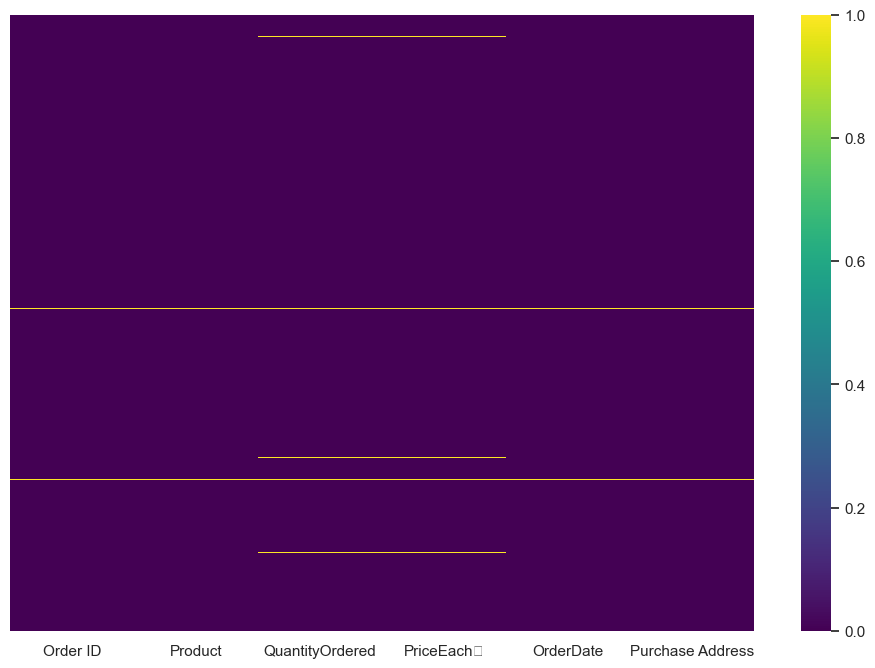

In [ ]:
sns.heatmap(cleaned_data.isna(), yticklabels = False, cmap = "viridis");

--- 

In [ ]:
df = sns.load_dataset('titanic')
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [ ]:
df['sex'] = np.where(df['sex'] == 'male', 1, 0)

In [ ]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,1,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,0,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,0,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,0,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,1,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,0,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,0,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,1,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


---
Pie charts ou camembert


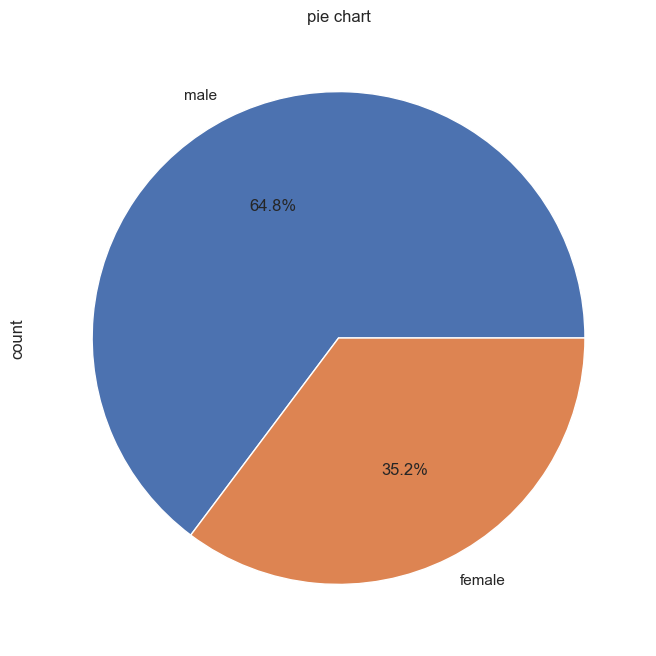

In [ ]:
df['sex'].value_counts().plot(kind = 'pie',
                              autopct = '%1.1f%%',
                              title = 'pie chart');  

Generalisation:

- Le code suivant vous permet de creer autant de pie charts que vous souhaitez mais attention, n'utilisez que pour les variables NOMINALES(ayant un nombre reduit de modalites)

In [ ]:
df.select_dtypes(exclude = 'number').head()

,sex,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,male,S,Third,man,True,NaN,Southampton,no,False
1,female,C,First,woman,False,C,Cherbourg,yes,False
2,female,S,Third,woman,False,NaN,Southampton,yes,True
3,female,S,First,woman,False,C,Southampton,yes,False
4,male,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
for i, colname in enumerate(df.select_dtypes(exclude = 'number')):
    print(i, colname)

0 sex
1 embarked
2 class
3 who
4 adult_male
5 deck
6 embark_town
7 alive
8 alone


In [ ]:
c = df.select_dtypes(exclude = 'number').shape[1]
c

9

In [ ]:
def mypiechart(df = df, nrows = 4, ncols = 3, mysize = (10, 10)):
    fig, ax = plt.subplots(nrows, ncols, figsize = mysize)
    for i, colname in enumerate(df.select_dtypes(exclude = 'number')):
        val = df[colname].value_counts()
        ax.flat[i].pie(val.values, labels = val.index, autopct = '%1.1f%%')
        ax.flat[i].set_title(colname)
    
    ax = ax.flatten()
    
    # fig.delaxes(ax[9])
    # fig.delaxes(ax[10])
    # fig.delaxes(ax[11])

    i = df.select_dtypes(exclude = 'number').shape[1]
    j = nrows*ncols 
    if j > i:
        for k in range(i, j):
            fig.delaxes(ax[k])
    
    fig.tight_layout()
    plt.show()

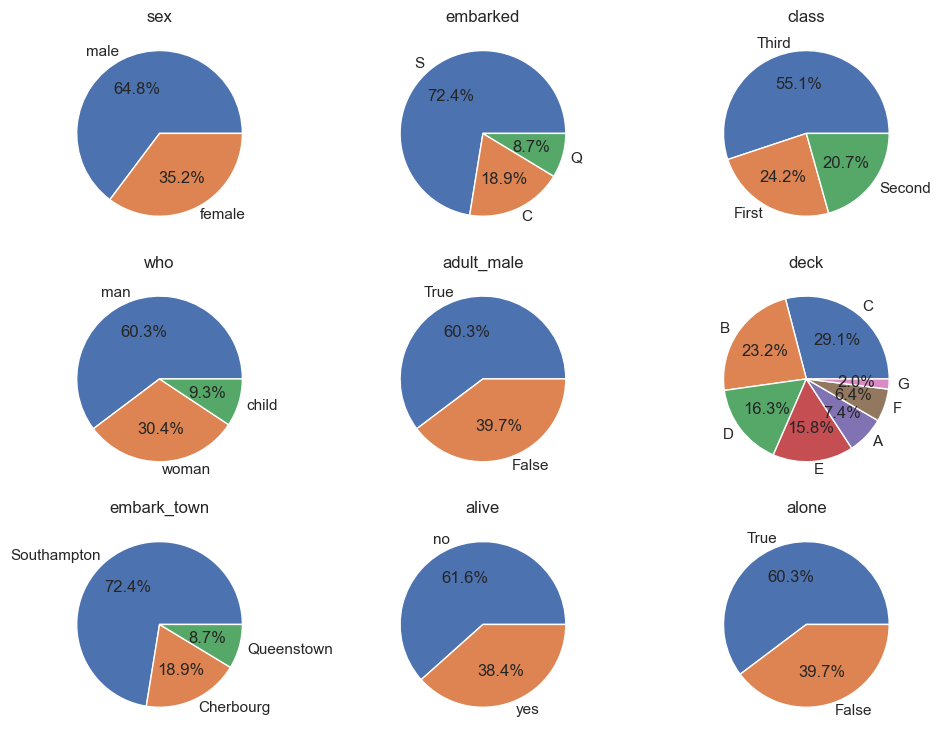

In [ ]:
mypiechart()

In [ ]:
for col in enumerate(df.select_dtypes(include = ['int64', 'float64'])):
    print(col[0], col[1])

0 survived
1 pclass
2 age
3 sibsp
4 parch
5 fare


<Axes: >

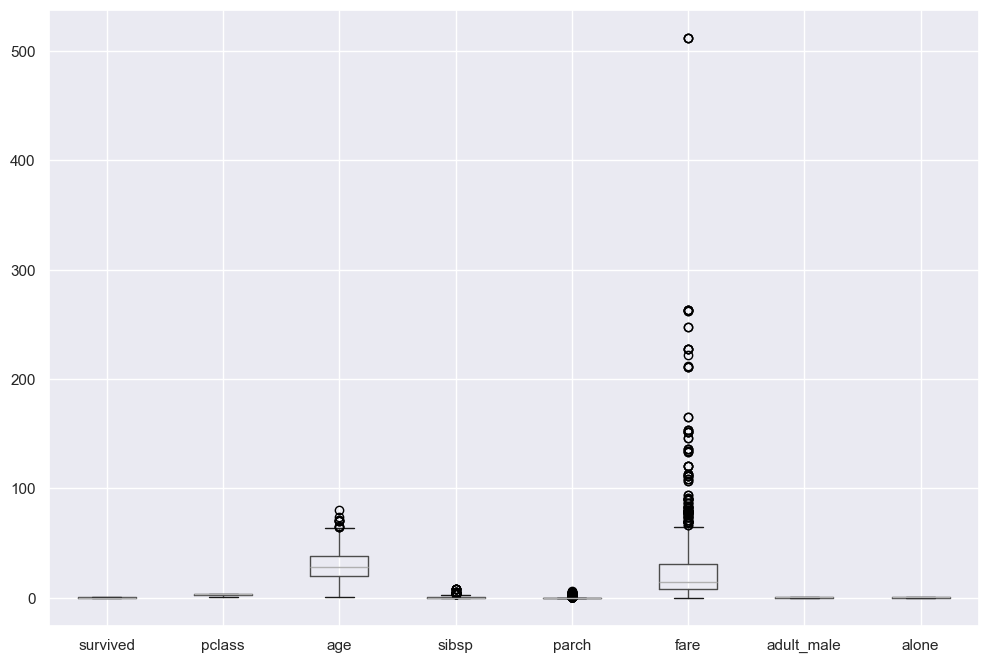

In [ ]:
df.boxplot()

In [ ]:
df.select_dtypes(include = 'number').head()

,survived,pclass,age,sibsp,parch,fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


---
- Boxplots avec la methode orientee objet

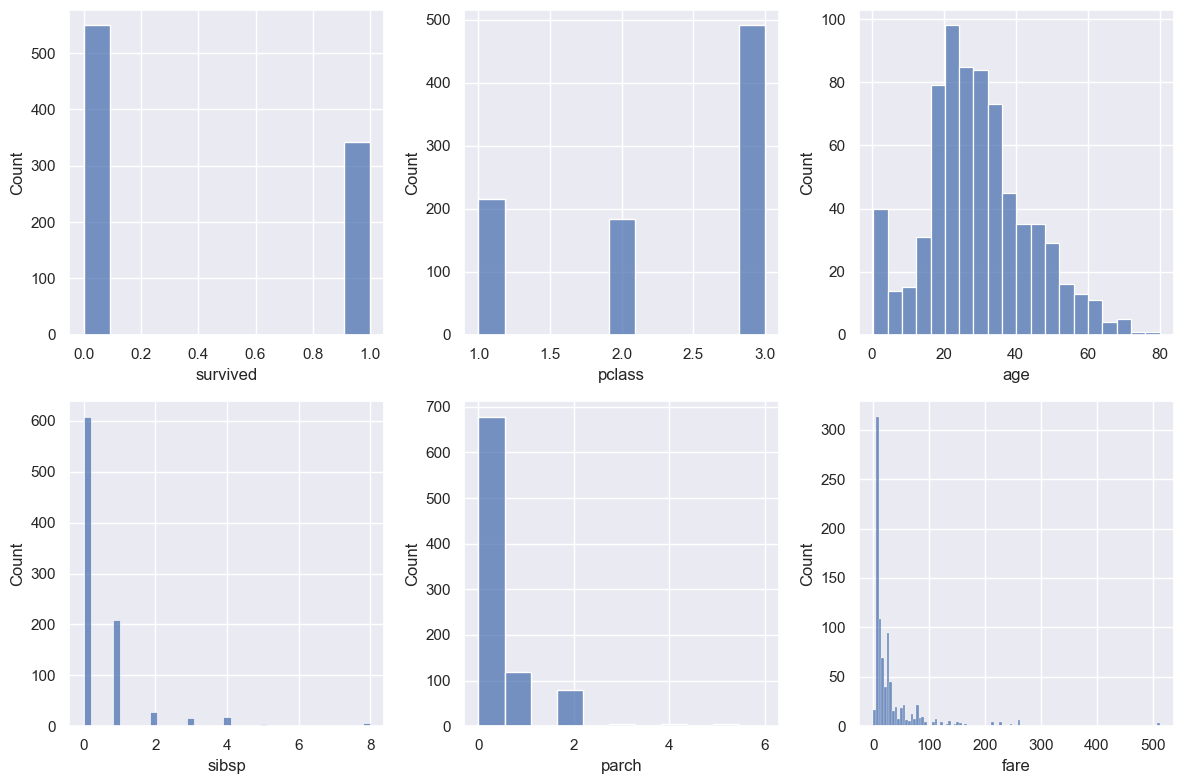

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 3)
ax = ax.flatten()
num_cols = df.select_dtypes(include = 'number')
for i, col in enumerate(num_cols):
    sns.histplot(x = col, ax = ax[i], data = df) 
plt.tight_layout()
plt.show()

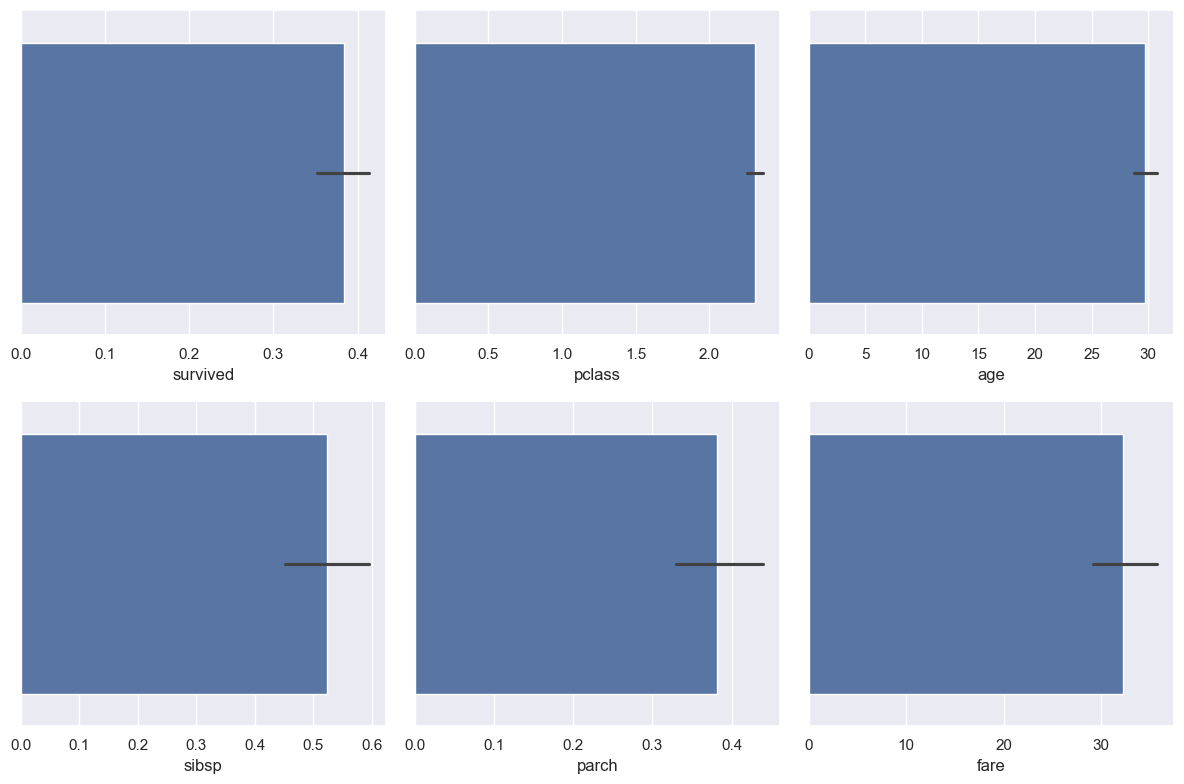

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 3)
ax = ax.flatten()
num_cols = df.select_dtypes(include = 'number')
for i, col in enumerate(num_cols):
    sns.barplot(x = col, ax = ax[i], data = df) 
plt.tight_layout()
plt.show()

In [ ]:
df.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')

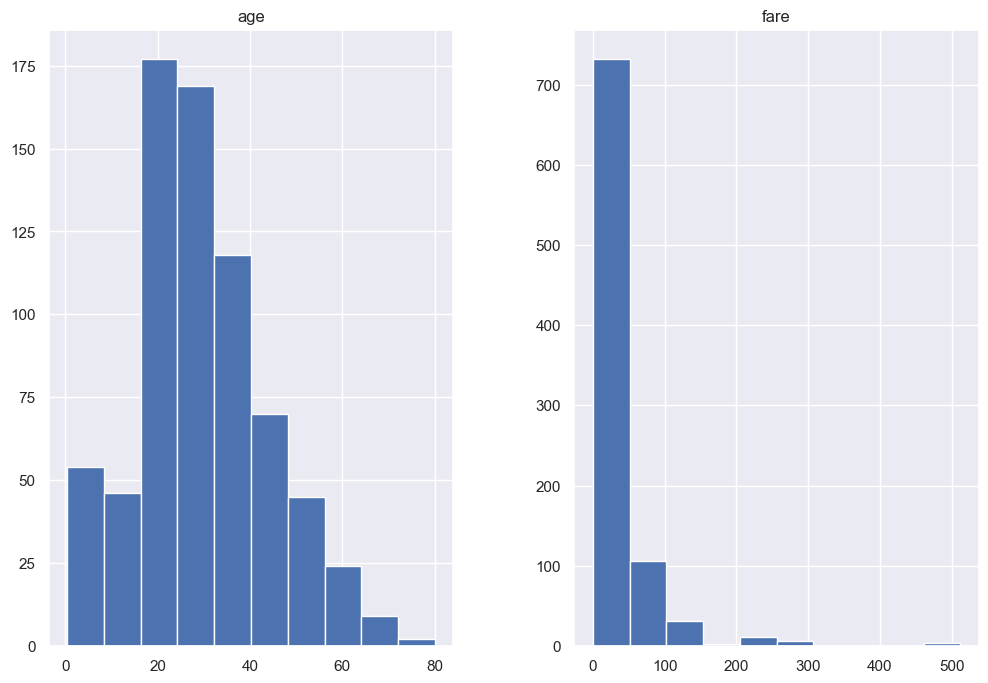

In [ ]:
df[['age', 'fare']].hist();

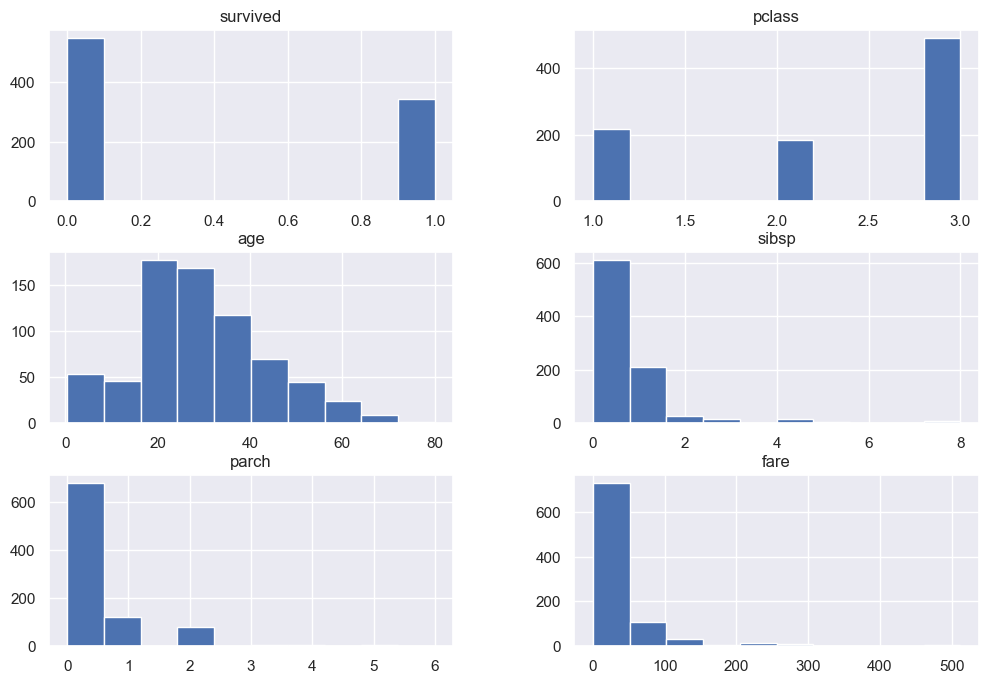

In [ ]:
df.hist();

---
- La methode non orientee objet

In [ ]:
def boxplots(df, nrows = 3, ncols = 3):
    for col in enumerate(df.select_dtypes(include = ['int64', 'float64'])):
            plt.subplot(nrows, ncols, col[0] + 1)
            sns.boxplot(y = col[1], color = 'C1', data = df) 
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

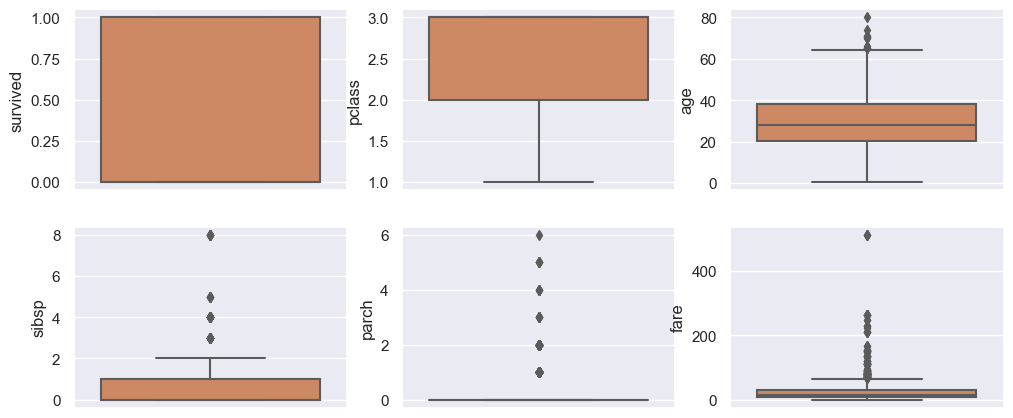

In [ ]:
boxplots(df)

---

- pairplot

/Users/jsb@56/draft/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


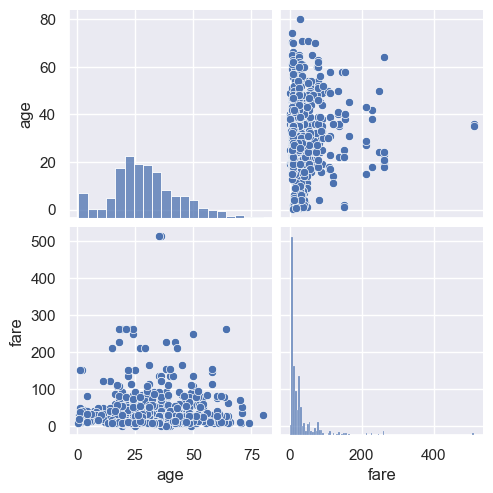

In [ ]:
sns.pairplot(data = df.select_dtypes('float'));

---

In [ ]:
df = pd.read_csv('employee.csv')
df.head()

,nom,age,langue,genre,nombre_enfant,titre,salaire
0,James,46.0,chinois,Masculin,7,Fonctionaire,269533.0
1,Haroun,71.0,arabe,Masculin,6,Fonctionaire,414675.0
2,Sherif,63.0,Russe,Masculin,4,Fonctionaire,273929.0
3,Cisse,60.0,Allemand,Masculin,0,Fonctionaire,467578.0
4,Robert,43.0,Allemand,Feminin,7,Retraite,762622.0


/Users/jsb@56/draft/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


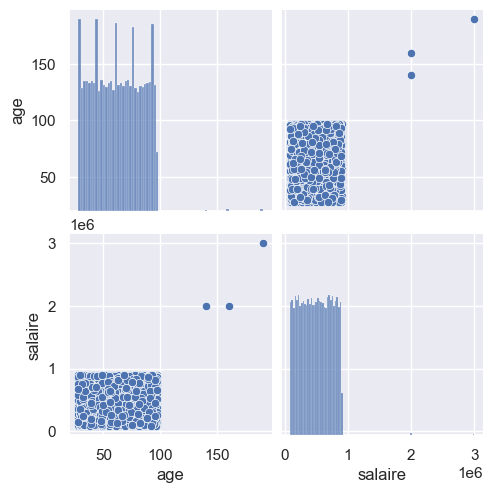

In [ ]:
sns.pairplot(data = df.select_dtypes('float'))

In [ ]:
def myheatmap(df):
    plt.figure(figsize=(6, 4))
    sns.heatmap(df.select_dtypes(['number']).corr(),
            annot = True, 
            cmap = 'coolwarm', 
            cbar = True, 
            annot_kws = {'fontsize': 10},
            vmin = -1,
            vmax = 1,
            lw = .1,
            # mask = np.triu(np.ones_like(df1.select_dtypes(['number']).corr()))
        )
    plt.title("Matrice de correlation")
    plt.show()

- Heatmap

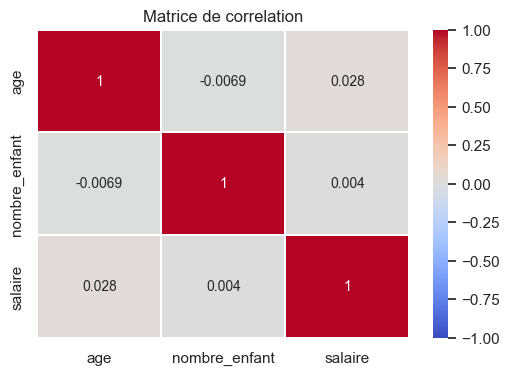

In [ ]:
myheatmap(df)

In [ ]:
df.head()

,nom,age,langue,genre,nombre_enfant,titre,salaire
0,James,46.0,chinois,Masculin,7,Fonctionaire,269533.0
1,Haroun,71.0,arabe,Masculin,6,Fonctionaire,414675.0
2,Sherif,63.0,Russe,Masculin,4,Fonctionaire,273929.0
3,Cisse,60.0,Allemand,Masculin,0,Fonctionaire,467578.0
4,Robert,43.0,Allemand,Feminin,7,Retraite,762622.0


In [ ]:
df.describe()

,age,nombre_enfant,salaire
count,34668.000000,35000.000000,3.393400e+04
mean,62.413263,3.505000,4.918323e+05
std,20.402716,2.292288,2.429100e+05
min,28.000000,0.000000,8.000300e+04
25%,45.000000,2.000000,2.845785e+05
50%,62.000000,4.000000,4.914040e+05
75%,80.000000,6.000000,6.974320e+05
max,190.000000,7.000000,3.000000e+06


In [ ]:
df.isna().sum()

nom                 0
age               332
langue              0
genre               0
nombre_enfant       0
titre               0
salaire          1066
dtype: int64

In [ ]:
# df['age'].mean()
df.select_dtypes('number').mean()

age                  62.413263
nombre_enfant         3.505000
salaire          491832.285260
dtype: float64

---
- Gestion de valeurs manquantes

In [ ]:
sns.set(rc = {"figure.figsize": (10, 4)})

In [ ]:
df.isna().sum()

nom                 0
age               332
langue              0
genre               0
nombre_enfant       0
titre               0
salaire          1066
dtype: int64

In [ ]:
def missingValues(df = df):   
    sns.heatmap(df.isnull(), yticklabels = False, cmap= "viridis", cbar = False)

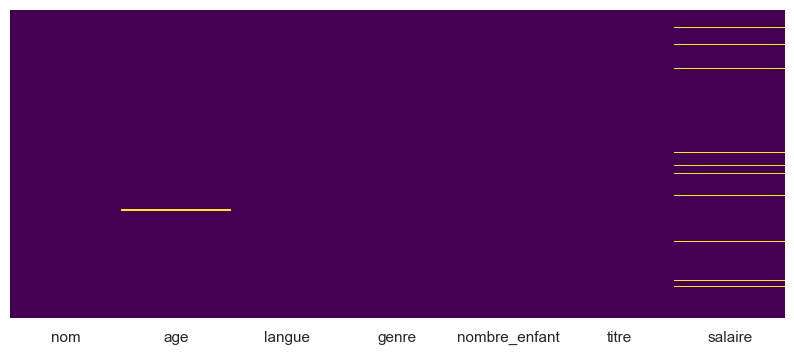

In [ ]:
missingValues()

In [ ]:
import numpy as np

def detect_outliers_zscore(df = df, threshold = 3.0):
    mean = np.mean(df)
    std = np.std(df)
    
    z_scores = [(x - mean) / std for x in df]
    outliers = [df[i] for i, z_score in enumerate(z_scores) if abs(z_score) > threshold]
    
    return outliers

# Exemple d'utilisation
data = [10, 15, 20, 25, 30, 35, 40, 45, 1000]
threshold = 2.5
outliers = detect_outliers_zscore(data, threshold)

print("Données originales:", data)
print("Valeurs aberrantes détectées:", outliers)

Données originales: [10, 15, 20, 25, 30, 35, 40, 45, 1000]
Valeurs aberrantes détectées: [1000]


In [ ]:
import numpy as np
import pandas as pd

def detect_outliers_zscore(dataframe, columns, threshold=3.0):
    outliers = pd.DataFrame()
    
    for column in columns:
        column_data = dataframe[column]
        mean = np.mean(column_data)
        std_dev = np.std(column_data)
        
        z_scores = [(x - mean) / std_dev for x in column_data]
        column_outliers = column_data[abs(z_scores) > threshold]
        outliers[column] = column_outliers
        
    return outliers

# Exemple d'utilisation
data = {
    'Feature1': [10, 15, 20, 25, 30, 35, 40, 45, 1000],
    'Feature2': [5, 8, 12, 18, 25, 28, 32, 38, 100]
}

df = pd.DataFrame(data)
threshold = 2.5
outliers = detect_outliers_zscore(df, columns=['Feature1', 'Feature2'], threshold=threshold)

print("DataFrame original:")
print(df)
print("\nValeurs aberrantes détectées:")
print(outliers)



TypeError: bad operand type for abs(): 'list'